In [112]:
from scipy.interpolate import UnivariateSpline, lagrange
from scipy.interpolate import Akima1DInterpolator, BarycentricInterpolator,PchipInterpolator

In [2]:
import scipy as sp

In [3]:
import numpy as np

In [4]:
from custom_numpy import arange_R_cst, arange_2d, is_sorted
from simulation_utils import gauss_ker, gaussian, SegmentedLagrange

In [5]:
import matplotlib.pyplot as plt

In [6]:
%matplotlib notebook

In [60]:
def getNDDCoeffs(x, y):
    """ Creates NDD pyramid and extracts coeffs """
    n = np.shape(y)[0]
    pyramid = np.zeros([n, n]) # Create a square matrix to hold pyramid
    pyramid[::,0] = y # first column is y
    for j in range(1,n):
        for i in range(n-j):
            # create pyramid by updating other columns
            pyramid[i][j] = (pyramid[i+1][j-1] - pyramid[i][j-1]) / (x[i+j] - x[i])
    return pyramid[0] # return first row


class Newton():
    
    def __init__(self, grid, grid_f):
        
        coeff_vector = getNDDCoeffs(grid, grid_f)
        
        # create as many polynomials as size of coeff_vector
        final_pol = np.polynomial.Polynomial([0.]) # our target polynomial
        n = coeff_vector.shape[0] # get number of coeffs
        for i in range(n):
            p = np.polynomial.Polynomial([1.]) # create a dummy polynomial
            for j in range(i):
                # each vector has degree of i
                # their terms are dependant on 'x' values
                p_temp = np.polynomial.Polynomial([-grid[j], 1.]) # (x - x_j)
                p = np.polymul(p, p_temp) # multiply dummy with expression
            p *= coeff_vector[i] # apply coefficient
            final_pol = np.polyadd(final_pol, p) # add to target polynomial

        self.p = np.flip(final_pol[0].coef, axis=0)
        
    def __call__(self, x):

        return np.polyval(self.p, x)

In [7]:
lam_range = [1.05,1.15]  # microns
R_2 = 1200
R_simu = 12000
oversample = 2

x = arange_R_cst(*lam_range, oversample*R_simu)
y = 1 - 0.5*gaussian(x, sig=np.array([1.1/R_simu])/(2 * np.sqrt(2 * np.log(2))), x0=np.array([1.1]))

c2 = gauss_ker(FWHM=np.array([R_simu/R_2]), oversample=oversample)

y = np.convolve(y, c2, mode='same')

x, y = x[500:-500],y[500:-500]
fy = UnivariateSpline(x,y, s=0)
x2 = arange_R_cst(x[0],x[-1], 2*R_2)
y2 = fy(x2)

In [86]:
i_newton = slice(57,63)
y_newton = Newton(x2[i_newton]-x2[i_newton].mean(),y2[i_newton])(x-x2[i_newton].mean())

In [109]:
y_spline = UnivariateSpline(x2,y2, s=0)(x)
y_lagrange = SegmentedLagrange(x2,y2,5, extrapolate=True)(x)

In [113]:
y_test = lagrange(x2[57:61]-x2[57:61].mean(),y2[57:61])(x-x2[57:61].mean())
y_pchip = PchipInterpolator(x2[56:62]-x2[56:62].mean(),y2[56:62])(x-x2[56:62].mean())

<IPython.core.display.Javascript object>


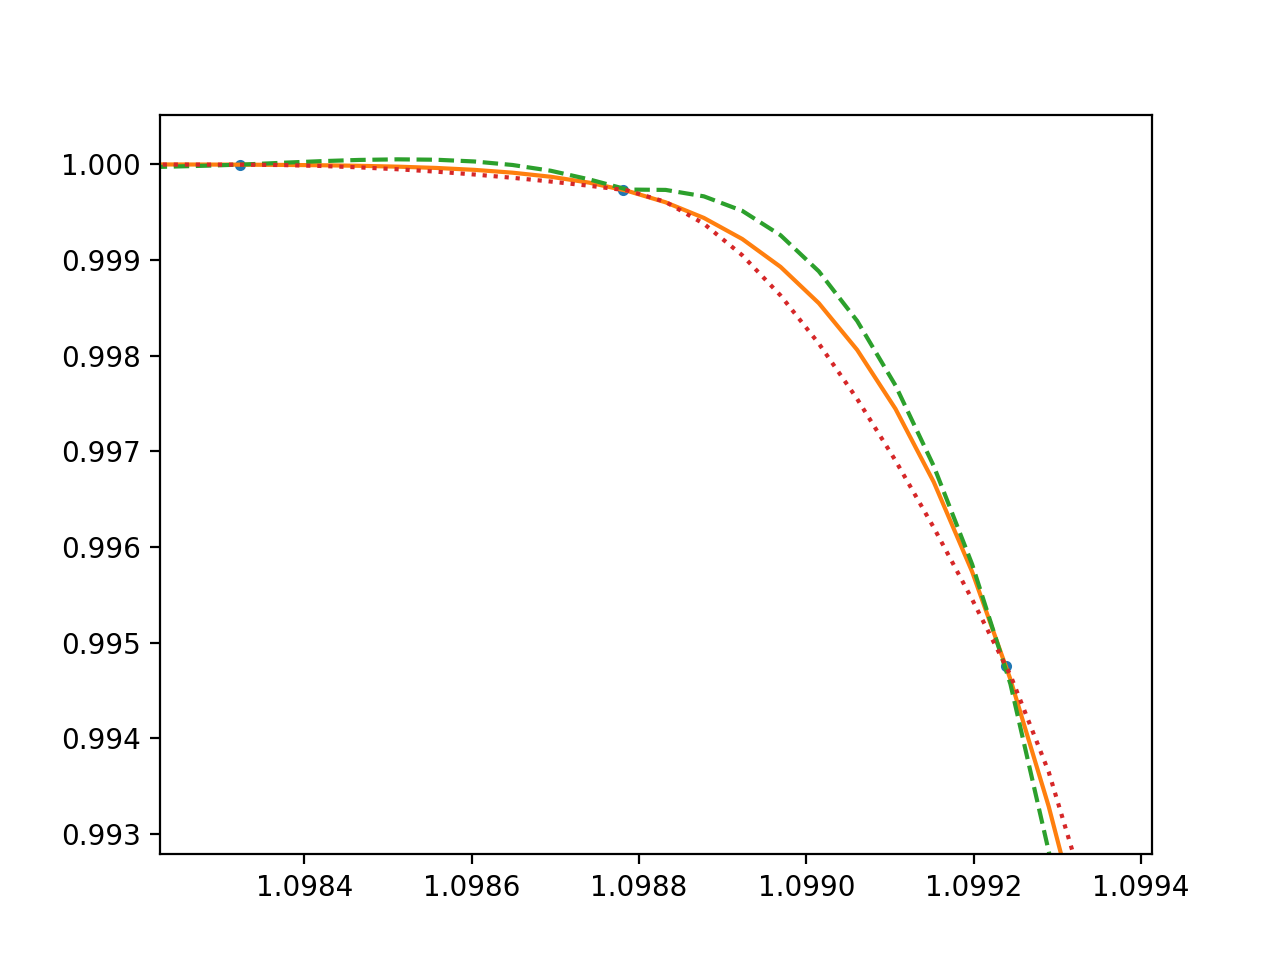

(0.965, 1.002)

In [115]:
plt.plot(x2,y2,".")
plt.plot(x,y)
# plt.plot(x2[55:65],y2[55:65],"x")
plt.plot(x,y_lagrange,"--")
plt.plot(x,y_pchip,":")

plt.ylim(0.965,1.002)

In [33]:

plt.plot(x,SegmentedLagrange(x2,y2,21, extrapolate=True)(x))

In [116]:
y_akima = Akima1DInterpolator(x2,y2)(x)
y_pchip = PchipInterpolator(x2,y2)(x)

<IPython.core.display.Javascript object>


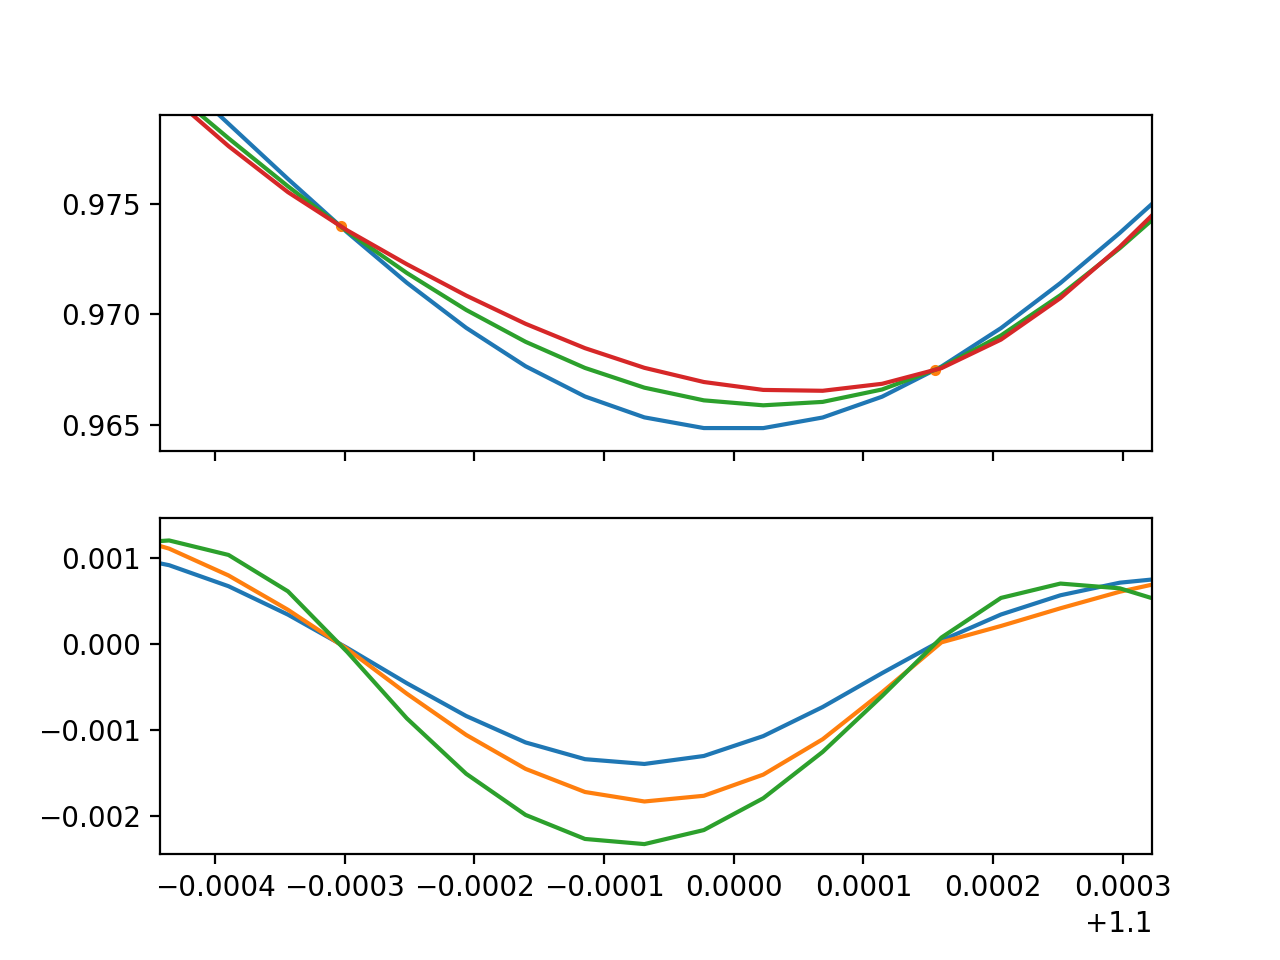

In [120]:
fig, ax = plt.subplots(2,1,sharex=True)

ax[0].plot(x,y)
ax[0].plot(x2,y2,".")
ax[0].plot(x,y_spline)
# ax[0].plot(x,y_lagrange)
ax[0].plot(x,y_akima)
# ax[0].plot(x,y_pchip)

ax[1].plot(x,(y-y_spline)/y)
ax[1].plot(x,(y-y_lagrange)/y)
ax[1].plot(x,(y-y_akima)/y)
# ax[1].plot(x,(y-y_pchip)/y)

# Not related. For JWST proposal...

In [5]:
def diss_profile(P, T, A_0, alpha, beta, gamma):
    
    # Dissociated Abundance
    log_A_d = alpha * np.log10(P) + beta/T + gamma
    A_d = 10.**log_A_d
    
    # Combine dissociated abundance with original abundance
    return (1/np.sqrt(A_0) + 1/np.sqrt(A_d))**-2

In [30]:
t_p = [[2560.647,0.942019],
[2490.566,0.7072062],
[2361.186,0.40337303],
[2328.841,0.32923782],
[2371.9678,0.2300741],
[2517.5203,0.16270982],
[2695.4177,0.12660892],
[2997.3047,0.061827302],
[3072.7764,0.044250116],
[3148.248,0.0294795],
[3223.7197,0.0229388],
[3309.9731,0.011891236],
[3336.9272,0.008017164],
[3374.663,0.0056024594],
[3455.5256,0.003732368],
[3487.8706,0.0023704886],
[3514.8247,0.0015419399],
[3520.2156,0.0010395879],
[3498.6523,6.0729287E-4],
[3455.5256,3.5902378E-4],
[3407.008,2.3076222E-4],
[3347.709,1.4310078E-4],
[3299.1914,1.0489439E-4]]


In [31]:
t,p = np.array(t_p).T

<IPython.core.display.Javascript object>


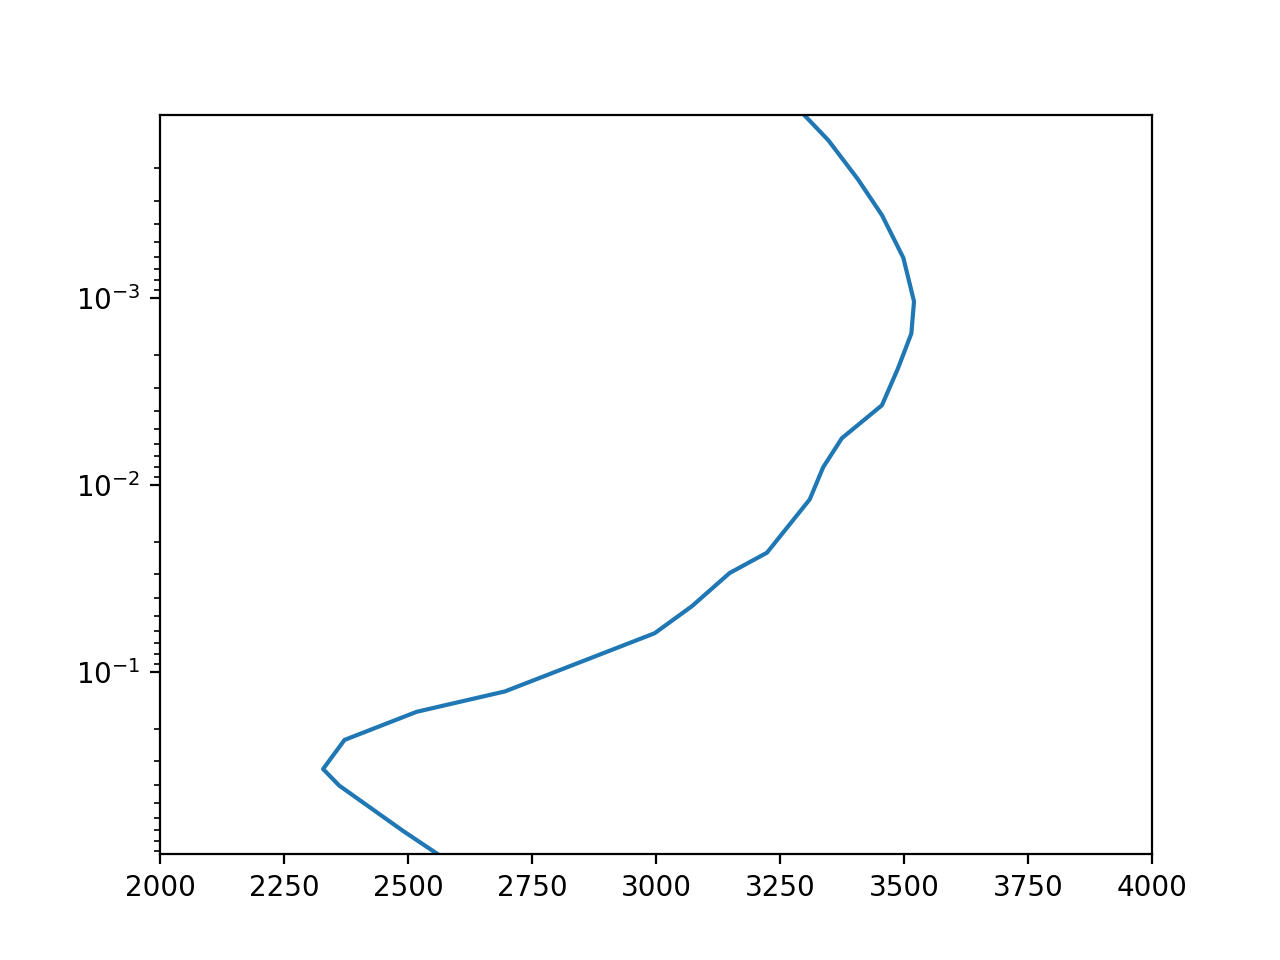

(2000, 4000)

In [8]:
plt.semilogy(t,p)
plt.ylim(p[0],p[-1])
plt.xlim(2000,4000)

In [47]:
p = 10**(np.linspace(2,-6,100))
t=np.ones(p.shape) * 3000
h2o = diss_profile(p,t,10**-3.3, 2,4.e-4,15.9)

In [46]:
plt.loglog(h2o,p)

<IPython.core.display.Javascript object>


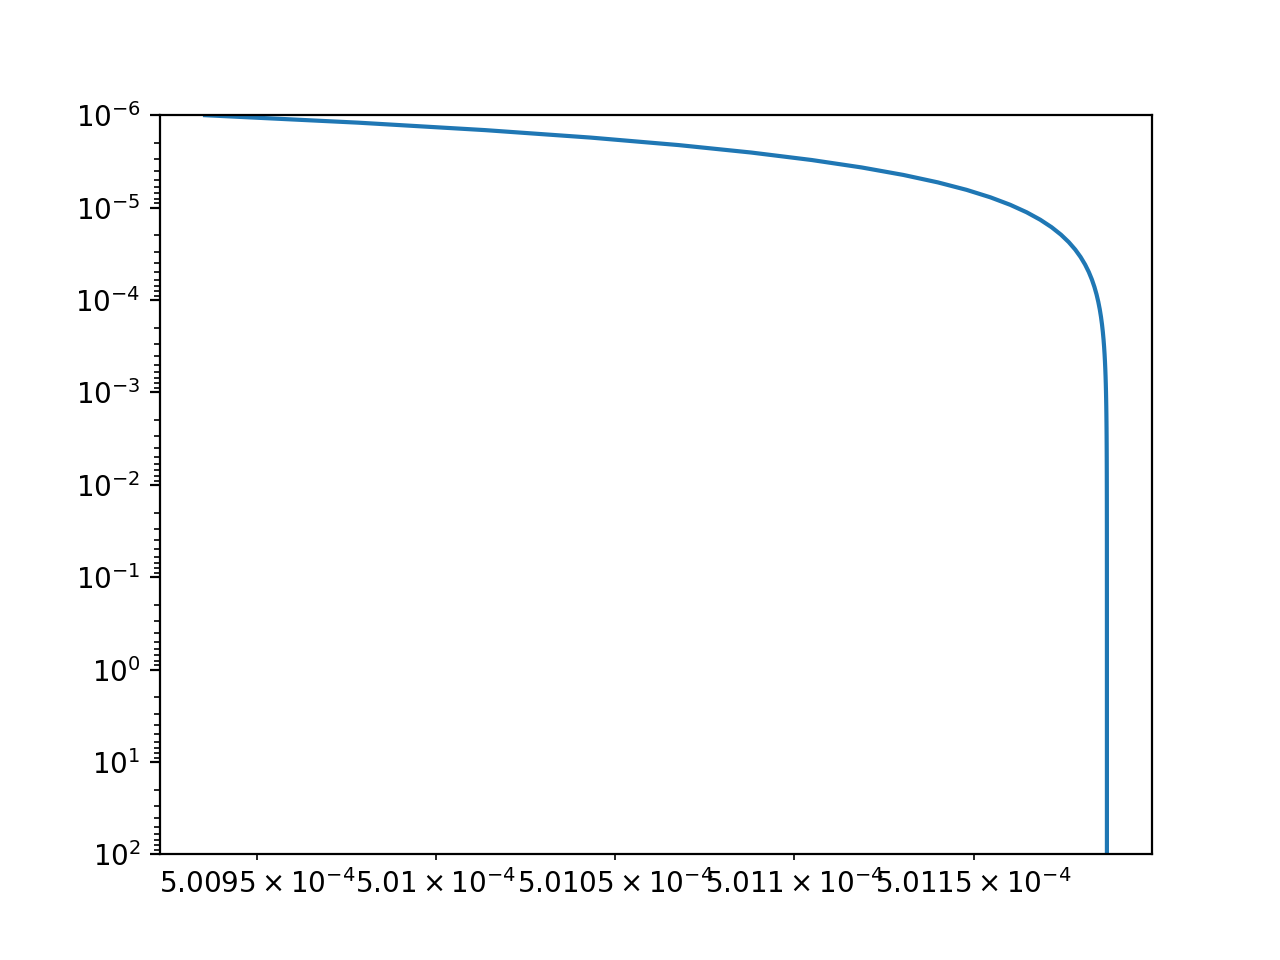

(100.0, 1e-06)

In [48]:
plt.figure()
plt.loglog(h2o,p)
plt.ylim(1e2,1e-6)
# plt.xlim(1e-12,1e0)